# PAF Calculations

## Starting with SBP -> HF 

This is from a categorical risk based on the SBP level of a simulant. Therefore, we will use the PAF equation and GBD risk exposure values to find the PAFs. 

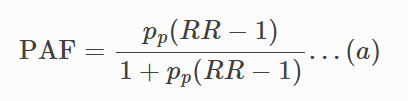

The Pp value is the percent exposed in the population. This can be found in the interactive model. However, this means that I only found it for Alabama. It will need to be done either nationally or for each state. 

In [1]:
import pandas as pd, numpy as np, os
from db_queries import get_ids, get_outputs, get_location_metadata, get_population, get_covariate_estimates
from get_draws.api import get_draws
import scipy.stats as sp
import scipy.integrate as integrate
import matplotlib.pyplot as plt
import random
import scipy.integrate as integrate
from risk_distributions import EnsembleDistribution
import math 
from typing import List, Tuple, Union

In [2]:
SBP_PAF = pd.DataFrame(np.array([['<120',1,1,1,0.44253490870032225],['120-129',1.13,1.27,1.43,0.24583780880773362],['130-139',1.3,1.5,1.73,0.1742749731471536],['140+',1.43,1.76,2.17,0.13735230934479054]]),
                   columns=['SBP_Group', 'RR_lower', 'RR', 'RR_upper','Pp'])
SBP_PAF

,SBP_Group,RR_lower,RR,RR_upper,Pp
0,<120,1,1,1,0.44253490870032225
1,120-129,1.13,1.27,1.43,0.24583780880773362
2,130-139,1.3,1.5,1.73,0.1742749731471536
3,140+,1.43,1.76,2.17,0.13735230934479054


In [3]:
SBP_PAF['Pp'] = pd.to_numeric(SBP_PAF['Pp'])
SBP_PAF['RR_lower'] = pd.to_numeric(SBP_PAF['RR_lower'])
SBP_PAF['RR'] = pd.to_numeric(SBP_PAF['RR'])
SBP_PAF['RR_upper'] = pd.to_numeric(SBP_PAF['RR_upper'])
SBP_PAF['RR_PP_lower'] = SBP_PAF.RR_lower * SBP_PAF.Pp
SBP_PAF['RR_PP'] = SBP_PAF.RR * SBP_PAF.Pp
SBP_PAF['RR_PP_upper'] = SBP_PAF.RR_upper * SBP_PAF.Pp
SBP_PAF

,SBP_Group,RR_lower,RR,RR_upper,Pp,RR_PP_lower,RR_PP,RR_PP_upper
0,<120,1.00,1.00,1.00,0.442535,0.442535,0.442535,0.442535
1,120-129,1.13,1.27,1.43,0.245838,0.277797,0.312214,0.351548
2,130-139,1.30,1.50,1.73,0.174275,0.226557,0.261412,0.301496
3,140+,1.43,1.76,2.17,0.137352,0.196414,0.241740,0.298055


In [4]:
RR_lower = SBP_PAF.RR_PP_lower.sum()
RR = SBP_PAF.RR_PP.sum()
RR_upper = SBP_PAF.RR_PP_upper.sum()

PAF_lower = (RR_lower - 1) / (RR_lower)
PAF = (RR - 1) / (RR)
PAF_upper = (RR_upper - 1) / (RR_upper)

print(PAF_lower, PAF, PAF_upper)

0.12534114983347655 0.20502516317370853 0.2824510731441321


## Now for BMI -> HF 

This is a continuous risk for the BMI of the simulant and its effect on HF. There is not as clear cut a formula for this type of risk. 

### Create the BMI pdf function

In [5]:
weights = pd.read_csv('/ihme/epi/risk/ensemble/_weights/gbd_2019/metab_bmi_adult.csv')
weights = weights.drop(columns=[c for c in weights.columns if '_id' in c]).loc[0]
weights

exp           0.001915
gamma         0.028420
invgamma      0.085432
llogis        0.187009
gumbel        0.220315
invweibull    0.140573
weibull       0.010840
lnorm         0.057513
norm          0.011908
glnorm        0.000000
betasr        0.135648
mgamma        0.007814
mgumbel       0.112612
Name: 0, dtype: float64

In [6]:
w_exponential = weights['exp']
w_gamma = weights['gamma']
w_inverse_gamma = weights['invgamma']
w_log_logistic = weights['llogis']
w_gumbel = weights['gumbel']
w_invweibull = weights['invweibull']
w_weibull = weights['weibull']
w_log_normal = weights['lnorm']
w_normal = weights['norm']
w_beta = weights['betasr']
w_mirror_gamma = weights['mgamma']
w_mirror_gumbel = weights['mgumbel']

In [7]:
params = get_draws(gbd_round_id=6,
         year_id=2019,
         sex_id=[1,2],
         location_id=523,
         age_group_id=[10,11,12,13,14,15,16,17,18,19,20,30,31,32],
         gbd_id_type='modelable_entity_id',
         gbd_id=[2548,18706],
         source='epi',
         decomp_step='step4')

In [8]:
data = params.set_index(['sex_id','modelable_entity_id','age_group_id'])
data = (data[[c for c in data.columns if 'draw' in c]].stack().reset_index()
        .rename(columns={'level_3':'draw',0:'value'}))
data['parameter'] = np.where(data.modelable_entity_id==2548, 'mean', 'standard_deviation')
data = data.drop(columns='modelable_entity_id')
data = (data.pivot_table(index=['sex_id','age_group_id','draw'], columns='parameter', values='value')
        .reset_index())
data.head()

parameter,sex_id,age_group_id,draw,mean,standard_deviation
0,1,10,draw_0,28.898947,9.591207
1,1,10,draw_1,29.912804,9.922810
2,1,10,draw_10,28.482101,5.695761
3,1,10,draw_100,27.270368,9.091147
4,1,10,draw_101,26.607156,3.859586


In [9]:
def bmi_ensemble(x, mean, std):
    result = (EnsembleDistribution({'betasr': [w_beta], 'exp': [w_exponential], 'gamma': [w_gamma], 'gumbel': [w_gumbel], 
                                 'invgamma': [w_inverse_gamma], 'invweibull': [w_invweibull], 'llogis': [w_log_logistic], 
                                 'lnorm': [w_log_normal], 'mgamma': [w_mirror_gamma], 'mgumbel': [w_mirror_gumbel], 
                                 'norm': [w_normal], 'weibull': [w_weibull]},
                                mean=mean, 
                                sd=std).pdf(x))
    return np.abs(result)

### Add in the RR's to the dataset

We start with a mean of 1.14 and a 95% confidence interval of 1.12 to 1.16. First, we will find the standard deviation. 

In [10]:
def get_lognorm_from_quantiles(median: float, lower: float, upper: float,
                               quantiles: Tuple[float, float] = (0.025, 0.975)) -> sp.lognorm:
    mu = np.log(median)
    stdnorm_quantiles = sp.norm.ppf(quantiles)
    norm_quantiles = np.log([lower, upper])
    sigma = (norm_quantiles[1] - norm_quantiles[0]) / (stdnorm_quantiles[1] - stdnorm_quantiles[0])
    return sp.lognorm(s=sigma, scale=median)

In [11]:
test2 = get_lognorm_from_quantiles(1.14,1.12,1.16).rvs(size=28000)

In [12]:
data['RR'] = test2
data.head()

parameter,sex_id,age_group_id,draw,mean,standard_deviation,RR
0,1,10,draw_0,28.898947,9.591207,1.143348
1,1,10,draw_1,29.912804,9.922810,1.150357
2,1,10,draw_10,28.482101,5.695761,1.123277
3,1,10,draw_100,27.270368,9.091147,1.144880
4,1,10,draw_101,26.607156,3.859586,1.142177


In [13]:
MF = pd.read_csv('/ihme/homes/lutzes/heart_failure_MF.csv')
MF['age_group_id'] = np.where(MF['age_start']==25,10,np.where(MF['age_start']==30,11,np.where(MF['age_start']==35,12,np.where(MF['age_start']==40,13,np.where(MF['age_start']==45,14,np.where(MF['age_start']==50,15,np.where(MF['age_start']==55,16,np.where(MF['age_start']==60,17,np.where(MF['age_start']==65,18,np.where(MF['age_start']==70,19,np.where(MF['age_start']==75,20,np.where(MF['age_start']==80,30,np.where(MF['age_start']==85,31,np.where(MF['age_start']==90,32,0))))))))))))))
MF['sex_id'] = np.where(MF['sex']=='Male',1,2)
MF.head()

,Unnamed: 0,age_start,sex,sbp_delta_1,MF_SBP_1,age_group_id,sex_id
0,0,70,Male,1.630016,0.186288,19,1
1,1,75,Male,1.684865,0.192556,20,1
2,2,65,Male,1.625224,0.185740,18,1
3,3,55,Male,1.553343,0.177525,16,1
4,4,30,Male,1.445270,0.165174,11,1


In [14]:
data1 = data.merge(MF[['MF_SBP_1','age_group_id','sex_id']], on=['age_group_id','sex_id'])
data1.head()

,sex_id,age_group_id,draw,mean,standard_deviation,RR,MF_SBP_1
0,1,10,draw_0,28.898947,9.591207,1.143348,0.20049
1,1,10,draw_1,29.912804,9.922810,1.150357,0.20049
2,1,10,draw_10,28.482101,5.695761,1.123277,0.20049
3,1,10,draw_100,27.270368,9.091147,1.144880,0.20049
4,1,10,draw_101,26.607156,3.859586,1.142177,0.20049


In [15]:
data1['RR_adj'] = (1 - data1['MF_SBP_1']) * (data1['RR'] - 1) + 1
data1.head()

,sex_id,age_group_id,draw,mean,standard_deviation,RR,MF_SBP_1,RR_adj
0,1,10,draw_0,28.898947,9.591207,1.143348,0.20049,1.114608
1,1,10,draw_1,29.912804,9.922810,1.150357,0.20049,1.120212
2,1,10,draw_10,28.482101,5.695761,1.123277,0.20049,1.098561
3,1,10,draw_100,27.270368,9.091147,1.144880,0.20049,1.115833
4,1,10,draw_101,26.607156,3.859586,1.142177,0.20049,1.113672


### Add the TMREL based on a Uniform Distribution 

Note that these values should match what is in the simulation at the draw level. However, we don't have an output for the draw level from the sim today. So I am generating some values and then will coordinate with Steve to ensure we are aligned. 

In [16]:
np.random.seed(123)
test3 = np.random.uniform(20,25,28000)
test3

array([23.48234593, 21.43069667, 21.13425727, ..., 22.69692061,
       23.79778933, 20.02823239])

In [17]:
data1['TMREL'] = test3
data1.head()

,sex_id,age_group_id,draw,mean,standard_deviation,RR,MF_SBP_1,RR_adj,TMREL
0,1,10,draw_0,28.898947,9.591207,1.143348,0.20049,1.114608,23.482346
1,1,10,draw_1,29.912804,9.922810,1.150357,0.20049,1.120212,21.430697
2,1,10,draw_10,28.482101,5.695761,1.123277,0.20049,1.098561,21.134257
3,1,10,draw_100,27.270368,9.091147,1.144880,0.20049,1.115833,22.756574
4,1,10,draw_101,26.607156,3.859586,1.142177,0.20049,1.113672,23.597345


### Testing for an appropriate upper/lower/epsilon

In order to test for an appropriate error bound for the equation, I will make the function for a single row of data. This will allow it to run faster and so I can test epsilon values more easily. 

Since the standard deviations vary so greatly in the dataset, I am going to split the data into two half at a std of 8. I will then test for a value at 8+ std and a vlaue for the lowest std. 

In [18]:
def function3():
    return integrate.quad(lambda x: (bmi_ensemble(x, data1['mean'].iloc[0], 8)                                     
                                          *data1['RR_adj'].iloc[0]**((data1['TMREL'].iloc[0] - x + abs(data1['TMREL'].iloc[0] - x))/2)),
                          lower,upper,epsabs=0.0000001)

In [19]:
lower = 13
upper = 60
function3()

(1.0980464016541382, 7.373228783080776e-08)

I used 80 as the upper bound since we are also using this in the simulation. For the lower bound, using 11 as the lower limit and an epsilon of 0.00001, there was an ouput of 1.117. When I tried to decrease the lower bound further to 10, the function would not complete, even at an epsilon 100 times smaller (0.00000001). 

Therefore I selected the bounds of upper=80, lower=11, and epsilon=0.00001

In [20]:
def function4():
    return integrate.quad(lambda x: (bmi_ensemble(x, data1['mean'].iloc[11212], 3)                                     
                                          *data1['RR_adj'].iloc[11212]**((data1['TMREL'].iloc[11212] - x + abs(data1['TMREL'].iloc[11212] - x))/2)),
                          lower,upper,epsabs=0.000000001)

In [21]:
lower = 19
upper = 33
function4()

(0.9956649789977152, 7.816889202166281e-09)

I hand selected a row I thought might be problematic and set the std to 3, which is just below the lowest std I have seen. So with the extreme case of row 11212, the first time I could get it to run was lower=19, upper=33 and eplison=0.000000001. This is very different than the other rows I tested. 

### Running the actual function for PAFs

I took the list of draws used from the current model V&V to make this faster. 

In [22]:
draws_list = ([ 29, 232, 357, 394, 602, 629, 650, 680, 829, 946])

When I actually ran the function with my selected outputs from above, it still would not converge for certain age/sex/draw combinations. This does make sense since I only tested on one age/sex/draw and there might be variation. I slowly increased the lower bound until I found a value that would run. 

In [34]:
%%time
data_final_hf = pd.DataFrame()
for draw in [i for i in list(draws_list)]:
    print(f'calculating draw number {draw}')
    burden = []
    burden1 = []
    df = data1.loc[(data1.draw==f'draw_{draw}') & (data1.standard_deviation > 8)]
    for i in list(range(0,len(df))):
        denom = integrate.quad(lambda x: (bmi_ensemble(x, df['mean'].iloc[i], df['standard_deviation'].iloc[i])                                     
                                          * df['RR_adj'].iloc[i]**((df['TMREL'].iloc[i] - x + abs(df['TMREL'].iloc[i] - x))/2)),
                                                      13, 60,
                              epsabs=0.0000001)[0]
        burden.append(denom)
    df['burden'] = burden
    df['paf'] = (df['burden'] - 1) / df['burden']
    data_final_hf.append(df)
    df1 = data1.loc[(data1.draw==f'draw_{draw}') & (data1.standard_deviation < 8)]
    for i in list(range(0,len(df1))):
        denom1 = integrate.quad(lambda x: (bmi_ensemble(x, df1['mean'].iloc[i], df1['standard_deviation'].iloc[i])                                     
                                          * df1['RR_adj'].iloc[i]**((df1['TMREL'].iloc[i] - x + abs(df1['TMREL'].iloc[i] - x))/2)),
                                                      19, 33,
                              epsabs=0.000000001)[0]
        burden1.append(denom1)
    df1['burden'] = burden1
    df1['paf'] = (df1['burden'] - 1) / df1['burden']
    data_final_hf.append(df1)
    df.to_pickle(f'national_pafs_draw_{draw}')
    print(f'Draw {draw} completed')

calculating draw number 29
Draw 29 completed
calculating draw number 232
Draw 232 completed
calculating draw number 357
Draw 357 completed
calculating draw number 394
Draw 394 completed
calculating draw number 602
Draw 602 completed
calculating draw number 629
Draw 629 completed
calculating draw number 650
Draw 650 completed
calculating draw number 680
Draw 680 completed
calculating draw number 829


<timed exec>:18: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.


Draw 829 completed
calculating draw number 946
Draw 946 completed
CPU times: user 4h 24min 9s, sys: 33.3 s, total: 4h 24min 42s
Wall time: 4h 24min 9s


In [47]:
data_final_hf.head()

,sex_id,age_group_id,draw,mean,standard_deviation,RR,MF_SBP_1,RR_adj,TMREL,burden,paf
1941,1,11,draw_946,29.314019,5.862804,1.137315,0.165174,1.114634,22.439906,0.758018,-0.319231
3941,1,13,draw_946,29.435023,5.887005,1.157608,0.175462,1.129954,20.034330,0.741074,-0.349394
5941,1,15,draw_946,30.763709,6.144822,1.144210,0.170942,1.119558,20.126720,0.669203,-0.494314
6941,1,16,draw_946,30.846062,6.169212,1.148667,0.177525,1.122275,24.811464,0.698764,-0.431097
7941,1,17,draw_946,30.469042,6.017032,1.132217,0.179977,1.108421,22.537218,0.695171,-0.438494


In [44]:
data_final_hf.to_csv('/ihme/homes/lutzes/PAFs_BMI_HF_2.csv')

### BMI -> Ischemic Heart Disease

In [63]:
data_ihd = data[['sex_id','age_group_id','draw','mean','standard_deviation']]

In [66]:
ihd_rrs = get_draws(gbd_id_type='rei_id', 
                    gbd_id=370, 
                    source='rr', 
                    year_id=2019, 
                    gbd_round_id=6, 
                    status='best', 
                    decomp_step='step4')
ihd_rrs = ihd_rrs.loc[ihd_rrs.cause_id==493]

/ihme/homes/lutzes/.conda/envs/vivarium_nih_us_cvd/lib/python3.8/site-packages/get_draws/transforms/version_transforms.py:33: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[version_id_type_name] = version_id


,rei_id,modelable_entity_id,location_id,year_id,age_group_id,sex_id,cause_id,mortality,morbidity,metric_id,...,draw_991,draw_992,draw_993,draw_994,draw_995,draw_996,draw_997,draw_998,draw_999,model_version_id
47,370,9031,64,2019,19,1,493,1,1,3,...,1.333598,1.264901,1.314576,1.262498,1.356769,1.302189,1.280006,1.246518,1.344642,417614
48,370,9031,64,2019,20,1,493,1,1,3,...,1.268413,1.280616,1.194777,1.207121,1.316172,1.282573,1.276711,1.270741,1.282031,417614
49,370,9031,64,2019,18,1,493,1,1,3,...,1.357512,1.340766,1.351063,1.401333,1.351264,1.393830,1.301542,1.416631,1.335885,417614
50,370,9031,64,2019,16,1,493,1,1,3,...,1.452993,1.469650,1.476039,1.493487,1.477032,1.411949,1.484071,1.409091,1.547330,417614
51,370,9031,64,2019,11,1,493,1,1,3,...,2.094086,1.849121,2.013425,2.488597,2.030135,2.506732,1.706746,1.500652,2.257314,417614
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8242,370,9031,103,2019,30,1,493,1,1,3,...,1.191419,1.125513,1.183741,1.178399,1.191479,1.189147,1.232329,1.126192,1.263078,417614
8277,370,9031,103,2019,31,1,493,1,1,3,...,1.191419,1.125513,1.183741,1.178399,1.191479,1.189147,1.232329,1.126192,1.263078,417614
8312,370,9031,103,2019,32,1,493,1,1,3,...,1.191419,1.125513,1.183741,1.178399,1.191479,1.189147,1.232329,1.126192,1.263078,417614
8347,370,9031,103,2019,235,1,493,1,1,3,...,1.191419,1.125513,1.183741,1.178399,1.191479,1.189147,1.232329,1.126192,1.263078,417614


In [67]:
data2 = ihd_rrs.set_index(['sex_id','modelable_entity_id','age_group_id'])
data2 = (data2[[c for c in data2.columns if 'draw' in c]].stack().reset_index()
        .rename(columns={'level_3':'draw',0:'value'}))
data2['parameter'] = np.where(data2.modelable_entity_id==9031, 'mean', 'standard_deviation')
data2 = data2.drop(columns='modelable_entity_id')
data2 = (data2.pivot_table(index=['sex_id','age_group_id','draw'], columns='parameter', values='value')
        .reset_index())
data2 = data2.rename(columns = {'mean':'RR'})
data2.head()

parameter,sex_id,age_group_id,draw,RR
0,1,9,draw_0,3.510608
1,1,9,draw_1,1.740403
2,1,9,draw_10,1.525438
3,1,9,draw_100,2.891299
4,1,9,draw_101,2.206858


In [68]:
MF2 = pd.read_csv('/ihme/costeffectiveness/artifacts/vivarium_nih_us_cvd/raw_data/mediation_matrix_draw_gbd_2021_edited.csv')
IHD_MF = MF2.loc[(MF2.rei_id==370) & (MF2.cause_id==493)]
IHD_MF = IHD_MF.transpose()
IHD_MF.reset_index(inplace=True)
IHD_MF = IHD_MF.rename(columns = {75:'FPG',81:'SBP',88:'LDL','index':'draw'})
IHD_MF.head()

,draw,FPG,SBP,LDL
0,rei_id,370.000000,370.000000,370.000000
1,med_id,105.000000,107.000000,367.000000
2,cause_id,493.000000,493.000000,493.000000
3,mean_mediation,0.149278,0.311516,0.100209
4,draw_0,0.168698,0.288050,0.088317


In [69]:
data_ihd2 = data_ihd.merge(data2[['age_group_id','sex_id','draw','RR']], on=['age_group_id','sex_id','draw']).merge(IHD_MF[['draw','FPG','SBP','LDL']], on=['draw'])
data_ihd2['RR_adj'] = 1 + ((data_ihd2['RR'] - 1) * (1-data_ihd2['FPG']) * (1-data_ihd2['SBP']) * (1-data_ihd2['LDL']))
data_ihd2.head()

,sex_id,age_group_id,draw,mean,standard_deviation,RR,FPG,SBP,LDL,RR_adj
0,1,10,draw_0,28.898947,9.591207,3.510608,0.168698,0.28805,0.088317,2.354663
1,1,11,draw_0,30.768116,10.256039,2.094858,0.168698,0.28805,0.088317,1.590759
2,1,12,draw_0,31.168189,10.389089,1.685112,0.168698,0.28805,0.088317,1.369670
3,1,13,draw_0,30.308706,10.100829,1.665879,0.168698,0.28805,0.088317,1.359292
4,1,14,draw_0,31.454214,10.475955,1.591258,0.168698,0.28805,0.088317,1.319028


In [70]:
np.random.seed(123)
test3 = np.random.uniform(20,25,28000)
data_ihd2['TMREL'] = test3
data_ihd2.head()

,sex_id,age_group_id,draw,mean,standard_deviation,RR,FPG,SBP,LDL,RR_adj,TMREL
0,1,10,draw_0,28.898947,9.591207,3.510608,0.168698,0.28805,0.088317,2.354663,23.482346
1,1,11,draw_0,30.768116,10.256039,2.094858,0.168698,0.28805,0.088317,1.590759,21.430697
2,1,12,draw_0,31.168189,10.389089,1.685112,0.168698,0.28805,0.088317,1.369670,21.134257
3,1,13,draw_0,30.308706,10.100829,1.665879,0.168698,0.28805,0.088317,1.359292,22.756574
4,1,14,draw_0,31.454214,10.475955,1.591258,0.168698,0.28805,0.088317,1.319028,23.597345


In [ ]:
%%time
data_final_ihd = pd.DataFrame()
for draw in [i for i in list(draws_list)]:
    print(f'calculating draw number {draw}')
    burden = []
    burden1 = []
    df = data_ihd2.loc[(data_ihd2.draw==f'draw_{draw}') & (data_ihd2.standard_deviation > 8)]
    for i in list(range(0,len(df))):
        denom = integrate.quad(lambda x: (bmi_ensemble(x, df['mean'].iloc[i], df['standard_deviation'].iloc[i])                                     
                                          * df['RR_adj'].iloc[i]**((df['TMREL'].iloc[i] - x + abs(df['TMREL'].iloc[i] - x))/2)),
                                                      13, 60,
                              epsabs=0.0000001)[0]
        burden.append(denom)
    df['burden'] = burden
    df['paf'] = (df['burden'] - 1) / df['burden']
    data_final_ihd.append(df)
    df1 = data_ihd2.loc[(data_ihd2.draw==f'draw_{draw}') & (data_ihd2.standard_deviation < 8)]
    for i in list(range(0,len(df1))):
        denom1 = integrate.quad(lambda x: (bmi_ensemble(x, df1['mean'].iloc[i], df1['standard_deviation'].iloc[i])                                     
                                          * df1['RR_adj'].iloc[i]**((df1['TMREL'].iloc[i] - x + abs(df1['TMREL'].iloc[i] - x))/2)),
                                                      19, 33,
                              epsabs=0.000000001)[0]
        burden1.append(denom1)
    df1['burden'] = burden1
    df1['paf'] = (df1['burden'] - 1) / df1['burden']
    data_final_ihd.append(df1)
    df.to_pickle(f'national_pafs_draw_{draw}')
    print(f'Draw {draw} completed')

In [ ]:
data_final_ihd.to_csv('/ihme/homes/lutzes/PAFs_BMI_IHD.csv')

### BMI -> Ischemic Stroke

In [71]:
data_stroke = data[['sex_id','age_group_id','draw','mean','standard_deviation']]

In [72]:
stroke_rrs = get_draws(gbd_id_type='rei_id', 
                    gbd_id=370, 
                    source='rr', 
                    year_id=2019, 
                    gbd_round_id=6, 
                    status='best', 
                    decomp_step='step4')
stroke_rrs = stroke_rrs.loc[stroke_rrs.cause_id==495]

/ihme/homes/lutzes/.conda/envs/vivarium_nih_us_cvd/lib/python3.8/site-packages/get_draws/transforms/version_transforms.py:33: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[version_id_type_name] = version_id


In [73]:
data3 = stroke_rrs.set_index(['sex_id','modelable_entity_id','age_group_id'])
data3 = (data3[[c for c in data3.columns if 'draw' in c]].stack().reset_index()
        .rename(columns={'level_3':'draw',0:'value'}))
data3['parameter'] = np.where(data3.modelable_entity_id==9031, 'mean', 'standard_deviation')
data3 = data3.drop(columns='modelable_entity_id')
data3 = (data3.pivot_table(index=['sex_id','age_group_id','draw'], columns='parameter', values='value')
        .reset_index())
data3 = data3.rename(columns = {'mean':'RR'})
data3.head()

parameter,sex_id,age_group_id,draw,RR
0,1,9,draw_0,2.405075
1,1,9,draw_1,2.088226
2,1,9,draw_10,3.831654
3,1,9,draw_100,2.202777
4,1,9,draw_101,2.824795


In [75]:
stroke_MF = MF2.loc[(MF2.rei_id==370) & (MF2.cause_id==495)]
stroke_MF = stroke_MF.transpose()
stroke_MF.reset_index(inplace=True)
stroke_MF = stroke_MF.rename(columns = {76:'FPG',82:'SBP',89:'LDL','index':'draw'})
stroke_MF.head()

,draw,FPG,SBP,LDL
0,rei_id,370.000000,370.000000,370.000000
1,med_id,105.000000,107.000000,367.000000
2,cause_id,495.000000,495.000000,495.000000
3,mean_mediation,0.216638,0.646555,0.034331
4,draw_0,0.193331,0.645818,0.051478


In [76]:
data_stroke2 = data_stroke.merge(data3[['age_group_id','sex_id','draw','RR']], on=['age_group_id','sex_id','draw']).merge(stroke_MF[['draw','FPG','SBP','LDL']], on=['draw'])
data_stroke2['RR_adj'] = 1 + ((data_stroke2['RR'] - 1) * (1-data_stroke2['FPG']) * (1-data_stroke2['SBP']) * (1-data_stroke2['LDL']))
data_stroke2.head()

,sex_id,age_group_id,draw,mean,standard_deviation,RR,FPG,SBP,LDL,RR_adj
0,1,10,draw_0,28.898947,9.591207,2.405075,0.193331,0.645818,0.051478,1.380775
1,1,11,draw_0,30.768116,10.256039,2.220086,0.193331,0.645818,0.051478,1.330643
2,1,12,draw_0,31.168189,10.389089,1.919950,0.193331,0.645818,0.051478,1.249306
3,1,13,draw_0,30.308706,10.100829,1.738278,0.193331,0.645818,0.051478,1.200073
4,1,14,draw_0,31.454214,10.475955,1.809969,0.193331,0.645818,0.051478,1.219501


In [78]:
np.random.seed(123)
test3 = np.random.uniform(20,25,28000)
data_stroke2['TMREL'] = test3
data_stroke2.head()

,sex_id,age_group_id,draw,mean,standard_deviation,RR,FPG,SBP,LDL,RR_adj,TMREL
0,1,10,draw_0,28.898947,9.591207,2.405075,0.193331,0.645818,0.051478,1.380775,23.482346
1,1,11,draw_0,30.768116,10.256039,2.220086,0.193331,0.645818,0.051478,1.330643,21.430697
2,1,12,draw_0,31.168189,10.389089,1.919950,0.193331,0.645818,0.051478,1.249306,21.134257
3,1,13,draw_0,30.308706,10.100829,1.738278,0.193331,0.645818,0.051478,1.200073,22.756574
4,1,14,draw_0,31.454214,10.475955,1.809969,0.193331,0.645818,0.051478,1.219501,23.597345


In [ ]:
%%time
data_final_stroke = pd.DataFrame()
for draw in [i for i in list(draws_list)]:
    print(f'calculating draw number {draw}')
    burden = []
    burden1 = []
    df = data_stroke2.loc[(data_stroke2.draw==f'draw_{draw}') & (data_stroke2.standard_deviation > 8)]
    for i in list(range(0,len(df))):
        denom = integrate.quad(lambda x: (bmi_ensemble(x, df['mean'].iloc[i], df['standard_deviation'].iloc[i])                                     
                                          * df['RR_adj'].iloc[i]**((df['TMREL'].iloc[i] - x + abs(df['TMREL'].iloc[i] - x))/2)),
                                                      13, 60,
                              epsabs=0.0000001)[0]
        burden.append(denom)
    df['burden'] = burden
    df['paf'] = (df['burden'] - 1) / df['burden']
    data_final_stroke.append(df)
    df1 = data_stroke2.loc[(data_stroke2.draw==f'draw_{draw}') & (data_stroke2.standard_deviation < 8)]
    for i in list(range(0,len(df1))):
        denom1 = integrate.quad(lambda x: (bmi_ensemble(x, df1['mean'].iloc[i], df1['standard_deviation'].iloc[i])                                     
                                          * df1['RR_adj'].iloc[i]**((df1['TMREL'].iloc[i] - x + abs(df1['TMREL'].iloc[i] - x))/2)),
                                                      19, 33,
                              epsabs=0.000000001)[0]
        burden1.append(denom1)
    df1['burden'] = burden1
    df1['paf'] = (df1['burden'] - 1) / df1['burden']
    data_final_stroke.append(df1)
    df.to_pickle(f'national_pafs_draw_{draw}')
    print(f'Draw {draw} completed')

In [ ]:
data_final_stroke.to_csv('/ihme/homes/lutzes/PAFs_BMI_stroke.csv')